## Writeup

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

---

### Overview

As we learnt in the Advanced Lane Finding classroom, successful processing of a video stream or images in different environments requires more complex algorithms in addition to what we learnt in the first class. Specifically, it involves,

* Undistort the image
* Filtering based on color gradients
* Applying a perspective transformation to parallelize the lanes
* Using different schemes to identify the lane locales
* Identifying pixels that are part of the lanes
* Finding a quadratic function that match the pixel locations
* Plotting out the quadratic function to demarcate the lane

In the next few sections, I shall go through each of these stages, how they were solved and what challenges were faced in achieving the solution.

### Some notes about my submission
Along with this write up, I have submitted a jupyter notebook, the first cell of which is the implementation, and the subsequent cells in that notebook invoking ```test_harness()``` with different parameters to cover the different rubric elements. There are 5 calls, one each for:

1. Calibration and undistortion
2. Perspective transformation
3. Pipeline stage inspection
4. test_images processing
5. project_video processing

- Output images for tests 1-4 above are all stored in folder *output_images*<br>
    - Calibration step images have the string, *_cal_* embedded in the filenames
    - Perspective step images have the string, *_persp_* embedded in the filenames
    - Pipeline step images have the string, *_pp_* embedded in the filenames
    - test_images have filenames end with the string, *_out*
- The Pipeline stage test uses an image I extracted from the video. This image is located in the "video_clips" folder
- Processed video is in the same folder as the input video and has the same name with an added *_out*<br>

### Camera Calibration

Completion of this stage was relatively painless :-).
The calibration process employed the cv2.calibrateCamera() function, that takes as input arrays of image points and object points and returns a camera matrix and a set of distortion coefficients, both of which are used to rectify distortion due to the lens as well as those arising from projecting a real-world 3D view onto a 2D image plane.

Image points is an array of point coordinates from an input image. It was built by processing a set of chessboard images and finding the coordinates of the corners of each complete square in the image. The found coordinates are appended to the imgpoints array.

Object points is an array of coordinates identifying where the corresponding points in the Image points array should be located. The objpoints array is built in parallel to the Image points array, and we use a corner's coordinate as its object point.

Having built the objpoints and imgpoints array, I was able to run cv2.calibrateCamera() followed by cv2.undistort() to obtain an undistorted image. The result can be seen below.

__Source Code and Test Run Guidelines__

```calib_camera()``` beginning at line 123 in the project submission implements the calibration functionality and is run as part of ```basic_setup()```. The test for calibration and undistortion can be run by invoking ```test_harness(4)```

__Issues__

One issue I ran into is that while most images had 9x6 corners some had fewer, and while I could have rejected those images, I tried to incorporate them by dynamically adjusting the coordinates in the objpoints array to match the number of corners found. I was afraid the calibration routine would require all calibration points to be the same shape, but the different shapes worked. Thus I was able to use all files.

While I did run through a calibration exercise and "undistorted" the images, I did not see a functional improvement in the output of processed images, and the operation added another 10s to the processing of the project video. I therefore commented out the "undistort" stage from the pipeline during processing of videos and test_images.

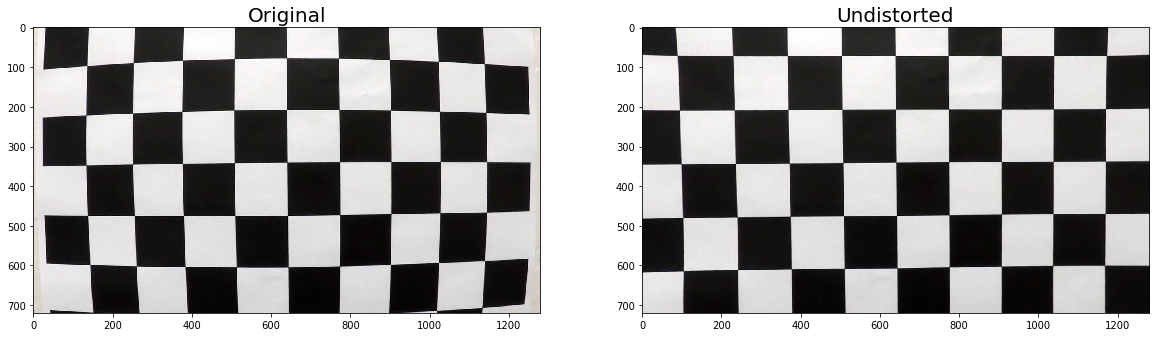

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

output_dir = "output_images/"
def visualize_imgs(img1, img2, tit1, tit2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1); ax1.set_title(tit1, fontsize=20)
    ax2.imshow(img2); ax2.set_title(tit2, fontsize=20)

img1 = plt.imread(output_dir + "calibration1_cal_Original.jpg")
img2 = plt.imread(output_dir + "calibration1_cal_Undistorted.jpg")

visualize_imgs(img1, img2, "Original", "Undistorted")
plt.show()

### Pipeline (single images) - Undistortion

#### Step 1 of the pipeline involves undistoring the image.
As the car's camera has a fixed focal length, we can carry 
forward the camera matrix and distortion coefficients obtained 
during the calibration phase for undistoring the test images.
We use the cv2.undistort() function to undistort the image.
The original and the resultant images are seen below.

I observed that there wasnt much difference in the Original and Undistorted images.
I therefore chose to engage the Undistort phase only when capturing the pipeline
stages, and forego the step during normal processing to make the pipeline go faster

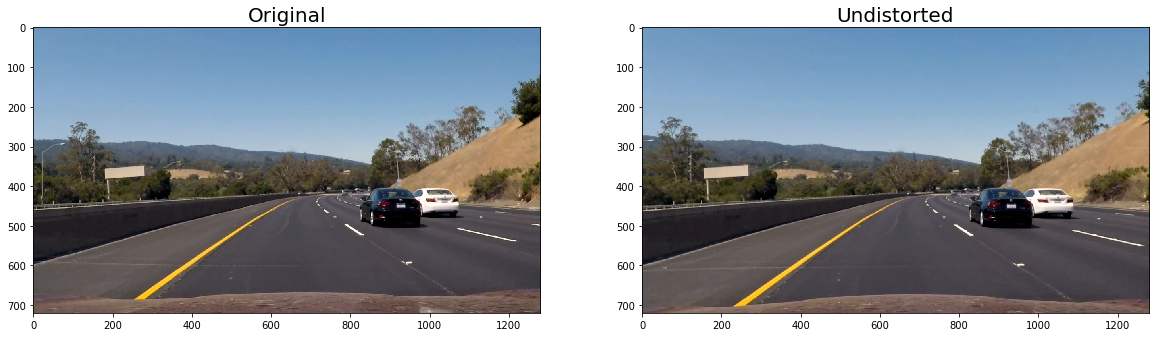

In [4]:
imgname = "project_video_clip_884"
img1 = plt.imread("video_clips/" + imgname + ".jpg")
img2 = plt.imread(output_dir + imgname + "_pp_Undistort.jpg")

visualize_imgs(img1, img2, "Original", "Undistorted")
plt.show()

### Pipeline (single images) - Thresholding

####  Step 2 of the pipeline involves filtering the image to keep only the lane markings and filtering out the rest as much as possible.
Filtering of the image is achieved by stripping out "weak" pixels, i.e. pixels that do not conform to certain thresholds. I started with the Sobel operator filter and a Saturation-based filter, however subsequently added a color filter as the other 2 did not suffice in certain cases. Following are the phases of this stage:

1) **Color Filter**: Certain frames in the video have cars whose pixels exhibited enough strength to pass through the Sobel and the saturation filter. Likewise, some frames that had heavily shaded areas, did not fare well with the Sobel and Saturation filters. I reasoned that lanes are either yellow or white, colors that are strong in the 'R' and 'G' components. I therefore built and applied a "RG" filter to help eliminate pixels from surrounding features. Thresholds used were **(210,210)** for the R and G components

2) **Sobel Operator**: Subsequent to the Color filter, I applied the Sobel operator along the X-axis. This does well in highlighting vertical features, and as lane markers are somewhat vertical, this does well in picking then up. The thresholds used were **(40,100)** and were obtained by empirically trying different values. This was very time consuming. 

3) **Saturation Filter**: Finally, I used a filter on the saturation metric of the image. In bright light, the lane markers exhibit strong saturation levels and thus this filter helps in isolating them. The thresholds used were **(170,255)** and were obtained by empirically trying different values. This was very time consuming.

4) **Masking Region of Interest**: The last mechanism applied to remove extraneous details is masking out portions of the image that are unlikely to  contain lane markings. I chose a triangular region comprising of the bottom, left and right endpoints of the image, and the center of the image, i.e, the region between (0,720), (640,360), (1280,720). On inspection, this region did not clip out any lane areas for the project_video, and thus was suitable for use.

The Color filter was applied to a RGB image, while the Sobel and the Saturation filters are applied after transforming the image into a gray-scale image. The following image shows the result of this stage of the pipeline.

__Source Code__

Lines 179-265 contain the code that control the thresholding mechanisms, and lines 266-320 contain the masking code.


```thresholding()```: Entry point into the thresholding functionality. Invokes functions to apply the Sobel and Saturation filters, and subsequently masking the region-of-interest<br>
```apply_sobel()```: Applies the color filter by invoking ```apply_colorfilter()``` followed by the Sobel operator. The resultant image is further filtered to remove "weak" pixels<br>
```apply_satthresh()```: Converts image to HLS, and retains pixels that match the saturation thresholds<br>
```apply_satthresh()```: Converts image to HLS, and retains pixels that match the saturation thresholds<br>
```apply_region_of_interest)_```: Defines the boundaries of the region-of-interest and then proceeds to mask out everything outside the region


### Filtered / Thresholded Image

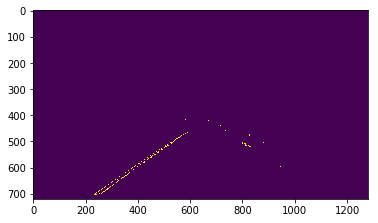

In [6]:
img1 = plt.imread(output_dir + imgname + "_pp_Threshold.jpg")

plt.imshow(img1, cmap='gray')

### Pipeline (single images) - Perspective Transformation

#### Step 3 of the pipeline involves applying a perspective transformation to the image so as to straighten out the lanes

In a "normal" view, wherein lanes appear to converge at a point on the horizon, it gets very complicated to accurately identify lane markers especially as the environment changes - lanes curving, objects moving in/out of the frame, darkly shaded areas, etc. By straightening out the lanes, one can obtain polynomial functions that mimic the lanes' curvatures, and this can help mark out lanes in areas where the lane markers are missing (dashed lanes), or are difficult to isolate (due to noise or lack of prominence). This can be done by applying a perspective transformation, which involves mapping 4 source points (what is) to 4 destination points (where they should be). By trying different combinations, I arrived at the following mapping:

| Position     | SRC COORDS  | DST COORDS  |
|:------------:|:-----------:|:-----------:|
| Top Left     | (450, 450)  | (170, 210)  |
| Top Right    | (900, 450)  | (1180, 210) |
| Bottom Left  | (300, 630)  | (500, 680)  |
| Bottom Right | (1100, 630) | (900, 680)  |


I verified that my perspective transform was working by drawing the `src` points on a test image and verifying that the test lines "warp" to form a rectangle in the "warped" image. This transformation can be seen below:

__Source Code__

Lines 323-365 contain the code that implements the perspective transformation. Functions involved are,

```chg_perspective()```: Defines the src and dst points and invokes ```apply_pers_chg()``` to effectuate the transformation<br>
```apply_pers_chg()```: Given a set of src, dst points, invoke cv2.getPerspectiveTransform() and cv2.warpPerspective() to get the warped results. The same function is used in reverse to "unwarp" images.


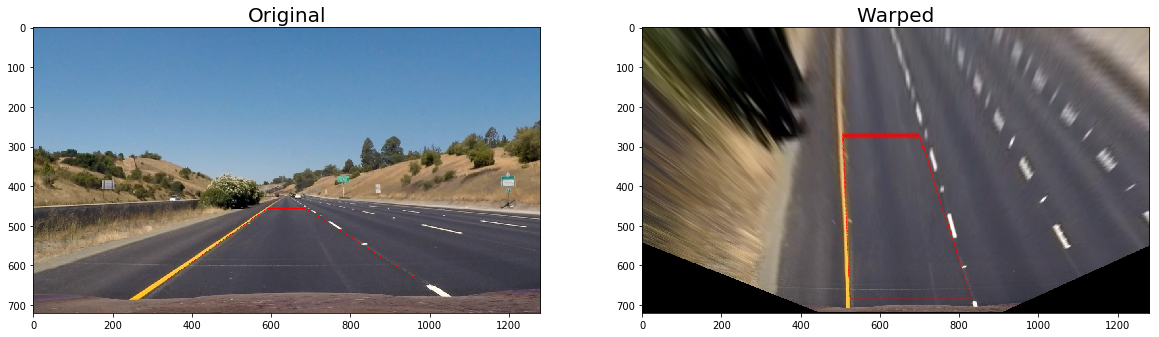

In [8]:
comptname = "straight_lines1"
img1 = plt.imread(output_dir + comptname + "_persp_Original.jpg")
img2 = plt.imread(output_dir + comptname + "_persp_Warped.jpg")

visualize_imgs(img1, img2, "Original", "Warped")
plt.show()

### Warped Image

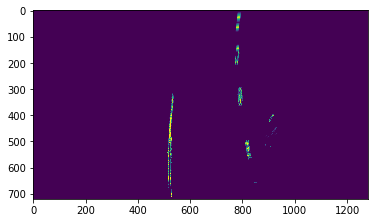

In [9]:
img1 = plt.imread(output_dir + imgname + "_pp_Warp.jpg")

plt.imshow(img1, cmap='gray')

### Pipeline (single images) - Finding Lane Pixels

#### Step 4 involves identifying and plotting the lane markers

This stage is where everything comes together. Below I describe the 3 steps involved to identifying and plotting the lane markers.
1) **Finding pixels**
This phase involves identifying the pixels that constitute the Left and Right lane markers. This is achieved by plotting a histogram of the image, rational being that as a histogram aggregates pixels columnwise, and so lanes that are now (near) vertical should aggregate into the highest values. We slice up the image in parts. Using the histogram values as starting lane positions, we start at the bottom of the image and move up the image in steps. At each step, we try to identify the lane pixels by searching for "live" pixels in a window in the vicinity of the current lane position. Reason for going up in slices is to adjust to curves in lanes

2) **Fitting a quadratic polynomial**
Once all the pixels that belong to the Left and Right lane markers have been identified we try to find a polynomial that fits the points obtained. Since lanes will have atmost a single curve in the region of interest, a quadratic polynomial suffices. Reason for finding and using a polynomial is to be able to extrapolate the lane markers in regions where no lane pixels were found

3) **Enumerating points**
This is a trivial exercise once a polynomial is found. We iterate through all possible values of y and using the polynomial equation, we find the corresponding x-coordinates, and plot them to obtain the lane markings.

The following image shows the output of the above stages. We see the pixels used to find the polynomial for the Left and Right lane markers in Red and Blue respectively, and the enumeration of the polynomial in yellow.

__Optimizations and Issues__
The above section highlights the general approach. Here we list optimizations and exceptions to the approach

**Optimizations:** When we process subsequent frames of a video stream, lanes are likely to continue their curvature at the beginning of the frame from the end of the previous frame. Thus, we can use the polynomial from the previous frame to help us locate the positions of lanes in the next frame. This is achieved in ```find_lane_pixels_byfit()```.

**Issues:** When a lane marker is dashed, often times we will encounter regions that have no lane pixels. In such cases, we use the polynomial from the last frame to mark a center and we use that in our calculations.

__Source Code__

Lines 408-801 is the code that implements the lane-finding algorithms. Following are the functions that are employed:<br><br>
**```fit_polynomial()```** - this is the entry point to finding the lane pixels. If a matching polynomial exists, it invokes ```find_lane_pixels_byfit()``` which uses the polynomial to find the potential lane markers. It also invokes, ```get_histpeaks()``` to find potential lane markers using the histogram approach. Subsequently, it invokes, ```resolve_hist_fit_peaks()``` to determine the better of the two sets and uses that to kick off the lane-pixel finding process<br><br>
```find_lane_pixels_bywin()``` - This is the next step in the process. This function divides the image into multiple intervals, and then iterates through interval attempting to find lane pixels. Lane pixels are searched for in bounded windows in the vicinity of the *current lane markers*. The curent lane marker is updated at the end of each interval - this is done by the function, ```get_next_win_centers()```.  All found pixels are then used to find a fitting polynomial which is resolved to find matching coordinates. **These matching coordinates define the lane**<br><br>


```resolve_hist_fit_peaks()``` - Given lane locations determined using an existing polynomial and using the histogram approach, pick the set that is a better fit. Uses the lane width to determine "better fit"<br><br>
```get_fitpeaks()``` - Envelop function for ```find_lane_pixels_byfit()```<br><br>
```get_histpeaks()``` - Calculate a histogram of all pixels and return the highest peak values as the possible lane locations<br><br>
```get_convolved_histpeaks()``` - Occassionally, the highest value in a histogram may not represent the position of the lane. Therefore when identifying histogram peaks, use peaks that exhibit a convolution strength as well. This is done using the *convolve algorithm*<br><br>
```find_lane_pixels_byfit()``` - Given a polynomial find the set of "live" pixels that match the polynomial<br><br>
```get_next_win_centers()``` - Given *current lane markers*, find the lane markers for the next slice. Use concentration of pixels in the current window as well as the last known polynomial to find the *current marker* for the next window.<br><br>



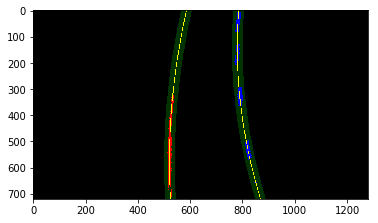

In [10]:
img1 = plt.imread(output_dir + imgname + "_pp_LaneFind.jpg")

plt.imshow(img1, cmap='gray')

### Pipeline (single images) - Radius of curvature and car position

#### Step 5. The final stage of the pipeline is to determine the radii of curvatures and the car position.

As a lane is identified by a quadratic equation, its radius of curvature is given by the 2nd derivative of the polynomial function. We calculate this using the highest possible value of y as that is the position closest to the car. <br>
The radius of curvature thus calculated is in pixels. I convert it into meters, by equating the distance between the lanes in pixels to 3.7m - the actual lane width. The radius for both the left and right lanes are printed on the image.<br>
*Car position* is assumed to be at the center of the 2 lanes. By comparing this center with the center of the image, I determine if the car is to the left or right of center. I use the ratio of 3.7m to lane-width to determine the distance of the car from the center in terms of meters.

__Source Code__

Lines 369-405 implement the supporting code.

```measure_curvature_pixels()``` is the function used to measure the radii of curvatures, and the car position<br><br>
```imprint_curvature()``` is also used to determine the car offset and print the data on the output image




### Pipeline (single images) - Unwarping

#### Step 6. The final stage involved unwarping the image.

This was accomplished by calling the same chg_perspective() function with the src and dst points reversed. The following image shows the result:

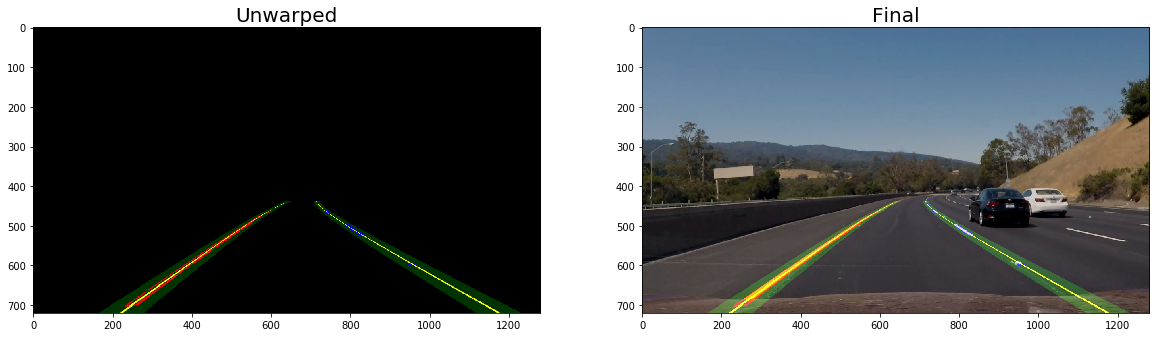

In [11]:
img1 = plt.imread(output_dir + imgname + "_pp_Unwarp.jpg")
img2 = plt.imread(output_dir + imgname + "_pp_Final.jpg")

visualize_imgs(img1, img2, "Unwarped", "Final")
plt.show()

### Pipeline (video)

The above pipeline was incorporated to process the project_video and the result is available at,

Here's a [link to my video result](./project_video_out.mp4)

__Issues__

During video processing there were 2 areas that proved to be problematic.
One area is around the 24s mark, and the other area is around the 41/42s mark.
In both cases, presence of dark shadows and/or lightening of the road color (from asphalt black to concrete gray), caused identifying lane pixels difficult. Histogram also failed ot identify the lane positions. Relying on the last known "good polynomial" helped get past these regions where it was difficult to distinguish the lane pixels.


### Discussion

__Issues and Known/Potential Failures__

* **Perspective Transformation src/dst points**<br>
The most difficult and time consuming portions for me were finding coordinates that can achieve a good perspective transformation. With a poor perspective transform, I was unable to get histogram to correctly identify starting lane positions due to substantial noise in the surrounding regions. I still do not understand how one can methodically (or scientifically) arrive at a valid perspective transformation src/dst sets.
* **Filtering schemes**<br>
* I noticed that with the challenge video my RG color filter eliminates significant parts of the lanes as well, so that will need to be modified.
* Secondly, saturation filter in "dull" lighting conditions seems to not be very useful. SO that will need to be revisited again.
* I am not comfortable with my "triangular" region-of-interest masking. it will lead to failures when lanes go off the side edge of a frame rather than the bottom edge, as is the case in the harder_challenge video.

__Improvements__
* **Filtering**<br>
* As I was reading up on Sobel operator, I learnt that it is a part of the Canny algorithm and that Canny does more, I would like to incorporate Canny into this exercise to determine if it fares better with lane identification
* **Finding lane pixels**<br>
* I think I have a good set of routines for finding lane pixels. I better understand the capabilities of each of my functions, and I think I can make them work together stronger and more efficiently. I would revisit how this set of functions interact and improve upon them to make lane finding more reliable.
* **Polynomial fit**<br>
* Having found a fitting polynomial, I would like to use it more in determining pixels for the next frame. However, I have seen polynomial fits that are incorrect. So I need to determine if a polynomial fit is truly a good fit. Not sure how to do this, but would like to explore this as well.
* **Robustness**<br>
* This is more on the lines of better coding - I dont have enough safe guards built in. So occasionally the program will quite due to empty tuples/arrays/lists being passed in. Would like to review this as well.

